In [5]:
import numpy as np
from time import time
import scipy.sparse as sps
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

%matplotlib inline

In [15]:
data = np.genfromtxt('web-Stanford.txt', dtype=[('FromNodeId', np.intp),
                                        ('ToNodeId', np.intp)])
P = sps.csr_matrix((np.ones(len(data)), (data['FromNodeId']-1, data['ToNodeId']-1)))
P += sps.identity(P.shape[0])
P = normalize(P, norm='l1', axis=0)

In [16]:
def result_function(x, P):
    return ((x - P.T@x)**2).sum()
def gradient(x, P):
    I = sps.identity(P.shape[0])
    return 2*(x - P.T@x).T@(I - P)

In [17]:
def proj(a, y):
 
    l = y/a
    idx = np.argsort(l)
    d = len(l)
    evalpL = lambda k: np.sum(a[idx[k:]]*(y[idx[k:]] - l[idx[k]]*a[idx[k:]]) ) -1
 
    def bisectsearch():
        idxL, idxH = 0, d-1
        L = evalpL(idxL)
        H = evalpL(idxH)
        if L<0:
            return idxL
 
        while (idxH-idxL)>1:
            iMid = int((idxL+idxH)/2)
            M = evalpL(iMid)
            if M>0:
                idxL, L = iMid, M
            else:
                idxH, H = iMid, M
        return idxH
 
    k = bisectsearch()
    lam = (np.sum(a[idx[k:]]*y[idx[k:]])-1)/np.sum(a[idx[k:]])
    x = np.maximum(0, y-lam*a)
 
    return x

#### method with $\alpha = \frac{1}{k+2}$

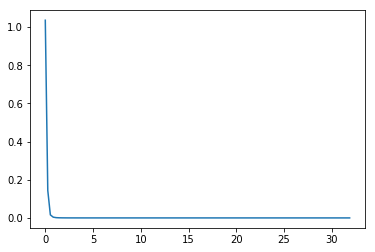

In [21]:
x = np.zeros(P.shape[0])
x[3] = 1
times = [0]
start_time = time()
losses = [result_function(x, P)]
for step in tqdm(range(100)):
    grad = gradient(x, P)
    alpha = 1/(step+2)
    x = x - alpha*grad
    x = proj(np.ones(x.shape[0]),x)
    loss = result_function(x, P)
    losses.append(loss)
    times.append(round(time()-start_time, 2))
plt.plot(times, losses)

In [22]:
np.save('pagerank/losses_GD.npy', losses)
np.save('pagerank/times_SGD.npy', times)

#### method with Polyak step

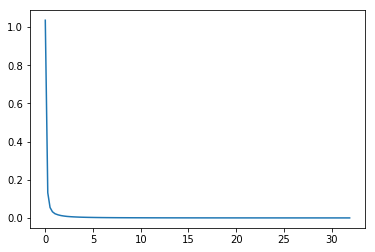

In [19]:
x = np.zeros(P.shape[0])
x[3] = 1
times = [0]
start_time = time()
losses = [result_function(x, P)]
for step in tqdm(range(100)):
    grad = gradient(x, P)
    alpha = losses[-1]/np.linalg.norm(grad)
    x = x - alpha*grad
    x = proj(np.ones(x.shape[0]),x)
    loss = result_function(x, P)
    losses.append(loss)
    times.append(round(time()-start_time, 2))
plt.plot(times, losses)

In [20]:
np.save('pagerank/losses_GD_polyak.npy', losses)
np.save('pagerank/times_GD_polyak.npy', times)